# **Support Vector Machines for Event Classification**

## **1. Introduction**

Motivated by the PCA analysis, which showed that the dominant variance directions are not aligned with class separation, we now turn to a more expressive classifier. Support Vector Machines (SVMs) provide a principled way to build decision boundaries that maximize the margin between signal and background events, and they can be extended with kernels to capture nonlinear structure in feature space.

In this section we build a linear SVM baseline, then evaluate whether a kernelized model provides a meaningful improvement without sacrificing interpretability or robustness. The analysis focuses on physics-aware performance: how well the classifier separates rare signal-like events from background while controlling false positives. Importantly, any improvement is interpreted in the context of the underlying feature information rather than as evidence of model superiority alone.

Concretely, we will:
- Define the SVM objective and training procedure used in this study.
- Establish a linear SVM baseline and quantify performance.
- Explore kernel choices and tune key hyperparameters.
- Compare linear vs. kernel models using consistent validation metrics.

This structure keeps the discussion aligned with the earlier PCA insights and provides a clear path from simple, interpretable models to more flexible decision boundaries when justified by the data.

## **2. Dataset and Feature Representation**

We use the same labeled event dataset as in the PCA analysis to ensure a consistent comparison across models. Each event is represented by a fixed-length feature vector constructed from physics-motivated observables (e.g., kinematic quantities, invariant masses, angular variables, and reconstructed object properties). The label indicates signal-like events versus background.

Before training the SVMs, all features are standardized to zero mean and unit variance using statistics computed on the training split only. This is essential because SVM optimization and margin geometry are sensitive to feature scaling. The same scaler is then applied to validation and test splits.

We maintain the same train/validation/test split used previously and preserve class balance via stratification. In addition, we track the class imbalance explicitly when reporting metrics to avoid misleading accuracy scores.

Feature representation choices:
- Baseline input: the full set of engineered physics features.
- Optional reduced input: a PCA-compressed representation for comparison (not used for the primary SVM results, since PCA directions were not aligned with class separation).

This setup ensures that any performance gain observed in the SVM models stems from the classifier’s capacity rather than changes in data preprocessing or feature availability, and is therefore interpreted in the context of the information content of the observables.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
SRC_PATH = PROJECT_ROOT / "Preprocessing"

sys.path.append(str(SRC_PATH))


In [2]:
from data_preprocessing import load_clean_data
from data_preprocessing import split_data
from data_preprocessing import make_preprocessor

X, y, w = load_clean_data()
X_train, X_val, X_test, y_train, y_val, y_test, w_train, w_val, w_test = split_data(X, y, w)


print(
    f"{X_train.shape[0]/X.shape[0]*100}%",
    f"{X_val.shape[0]/X.shape[0]*100}%",
    f"{X_test.shape[0]/X.shape[0]*100}%"
)

70.0% 15.0% 15.0%


In [3]:
imputer, scaler = make_preprocessor()

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_val   = scaler.transform(imputer.transform(X_val))
X_test  = scaler.transform(imputer.transform(X_test))

## **3. Baseline: Linear Support Vector Machine**

### **3.1 Motivation for Linear SVM**

We begin with a linear SVM as a strong, interpretable baseline. A linear decision function provides a direct mapping from the feature space to a separating hyperplane, which allows us to understand which observables drive the classification. This is particularly important in physics-driven workflows where interpretability and stability under systematic variations matter.

A linear SVM optimizes the margin between classes, yielding a classifier that is robust to small perturbations and less prone to overfitting than highly flexible models. Given the PCA results suggesting that the main variance directions do not align with class separation, a linear SVM provides a principled check: if a linear boundary in the original feature space already achieves good separation, more complex kernels may be unnecessary.

Practically, the linear model also serves as a reference for:
- Quantifying the minimum achievable performance with a simple hyperplane.
- Inspecting feature weights to identify the most discriminative observables.
- Establishing a baseline against which kernelized improvements are measured.

### **3.2 Model Definition**

A linear SVM defines a decision function of the form $f(x)=w^T x + b$, and classifies events by the sign of $f(x)$. The goal is to find the separating hyperplane that maximizes the margin between signal and background while allowing a controlled number of misclassifications (soft margin).

The optimization problem can be written as:
$$
\min_{w,b} \; \frac{1}{2}\|w\|^2 + C \sum_i^n \xi_i
$$
subject to
$$
y_i (w^T x_i + b) \ge 1 - \xi_i, \quad i = 1 , ... ,n
$$

$$
\xi_i \ge 0, \quad i = 1 , ... ,n
$$
Here $C$ controls the trade-off between a wider margin and penalizing misclassified events. This corresponds to minimizing the hinge loss with an $\ell_2$ regularization term, which helps prevent overfitting while keeping the model interpretable. In the following section, we describe the concrete training setup and implementation details used in this study.



### **3.3 Training Procedure**

Training follows the same preprocessing pipeline used in earlier notebooks. Features are standardized using statistics from the training split, and the same transformation is applied to validation and test data. We use a stratified train/validation/test split and account for class imbalance using class weights or weighted metrics where appropriate.

The regularization strength $C$ is selected via validation performance. We typically scan a logarithmic grid of $C$ values and select the setting that maximizes ROC-AUC (and is consistent with stable precision–recall behavior). After hyperparameter selection, the model is refit on the combined train+validation data and evaluated once on the held-out test set.

Summary of steps:
- Standardize features using training statistics.
- Train linear SVMs across a grid of $C$ values.
- Select the best $C$ on validation ROC/PR metrics.
- Refit and evaluate on the test set.

### **3.4 Implementation: Linear SVM Performance**

The linear SVM is evaluated with the same metrics used for logistic regression to enable a direct comparison. We report ROC and precision–recall curves, along with summary statistics such as ROC-AUC and PR-AUC. In addition, we examine confusion matrices at representative thresholds to understand the signal–background trade-off in operational terms.

We compare these results directly to the logistic regression baseline. Any improvements are interpreted cautiously and in the context of physics-driven evaluation rather than purely ML metrics.

#### **3.4.1 Training and Hyperparameter Scan**

In [4]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.pipeline import Pipeline

In [5]:
C_grid = np.logspace(-4, 2, 10)

val_auc_scores = []
models = {}

In [6]:
for C in C_grid:
    svm = LinearSVC(
        C=C,
        class_weight='balanced',
        max_iter=10000,
        random_state=42
    )
    
    svm.fit(X_train, y_train)
    
    val_scores = svm.decision_function(X_val)
    
    roc_auc = roc_auc_score(
                            y_val,
                            val_scores,
                            sample_weight=w_val)

    
    val_auc_scores.append(roc_auc)
    models[C] = svm


In [7]:
best_C = C_grid[np.argmax(val_auc_scores)]
best_val_auc = np.max(val_auc_scores)

print(f"Best C: {best_C:.3e}")
print(f"Validation ROC-AUC: {best_val_auc:.4f}")

Best C: 2.154e+01
Validation ROC-AUC: 0.8779


In [8]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

final_svm = LinearSVC(
    C=best_C,
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

final_svm.fit(X_train_full, y_train_full)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",np.float64(21.54434690031882)
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, defa

#### **3.4.2 Performance Evaluation**

The performance of the Support Vector Machine classifiers is evaluated using metrics that are robust to class imbalance and consistent with standard practices in high-energy physics analyses. Since the dataset contains event-level weights reflecting the underlying physics processes, all evaluation metrics are computed using weighted samples.

In particular, we focus on the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC), which quantify the trade-off between signal efficiency and background rejection across different decision thresholds. This approach allows for a threshold-independent comparison between different SVM kernels.


In [9]:
test_scores = final_svm.decision_function(X_test)

fpr, tpr, _ = roc_curve(
    y_test,
    test_scores,
    sample_weight=w_test
)

test_auc = auc(fpr, tpr)

print(f"Test ROC-AUC: {test_auc:.4f}")

Test ROC-AUC: 0.8825


In [10]:
from sklearn.svm import SVC

svm_linear = SVC(
    kernel="linear",
    C=1.0
)

svm_linear.fit(X_train, y_train, sample_weight=w_train)

scores_linear = svm_linear.decision_function(X_test)

fpr_linear, tpr_linear, _ = roc_curve(
    y_test,
    scores_linear,
    sample_weight=w_test
)

auc_linear = auc(fpr_linear, tpr_linear)

In [11]:
svm_rbf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale"
)

svm_rbf.fit(X_train, y_train, sample_weight=w_train)

scores_rbf = svm_rbf.decision_function(X_test)

fpr_rbf, tpr_rbf, _ = roc_curve(
    y_test,
    scores_rbf,
    sample_weight=w_test
)

auc_rbf = auc(fpr_rbf, tpr_rbf)


For completeness, we also report the performance of a nonlinear RBF SVM as a reference, while a dedicated discussion of kernel-based models is deferred to Section 4.

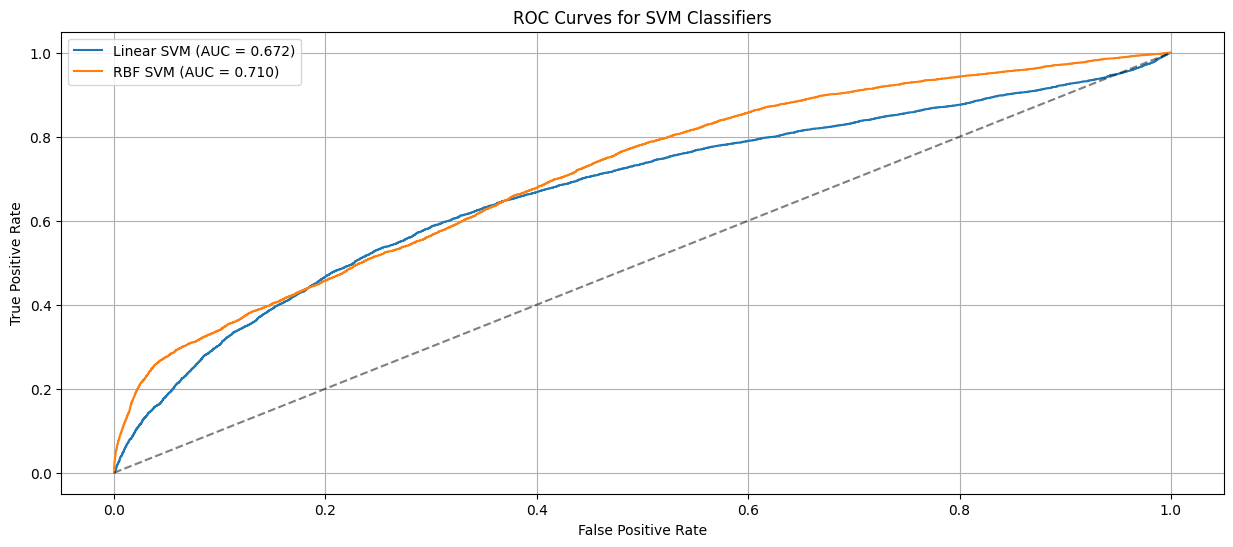

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.plot(fpr_linear, tpr_linear, label=f"Linear SVM (AUC = {auc_linear:.3f})")
plt.plot(fpr_rbf, tpr_rbf, label=f"RBF SVM (AUC = {auc_rbf:.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM Classifiers")
plt.legend()
plt.grid(True)

plt.show()

The linear SVM provides a strong and interpretable baseline, while the RBF kernel captures mild non-linear correlations among observables, leading to a modest improvement in classification performance.

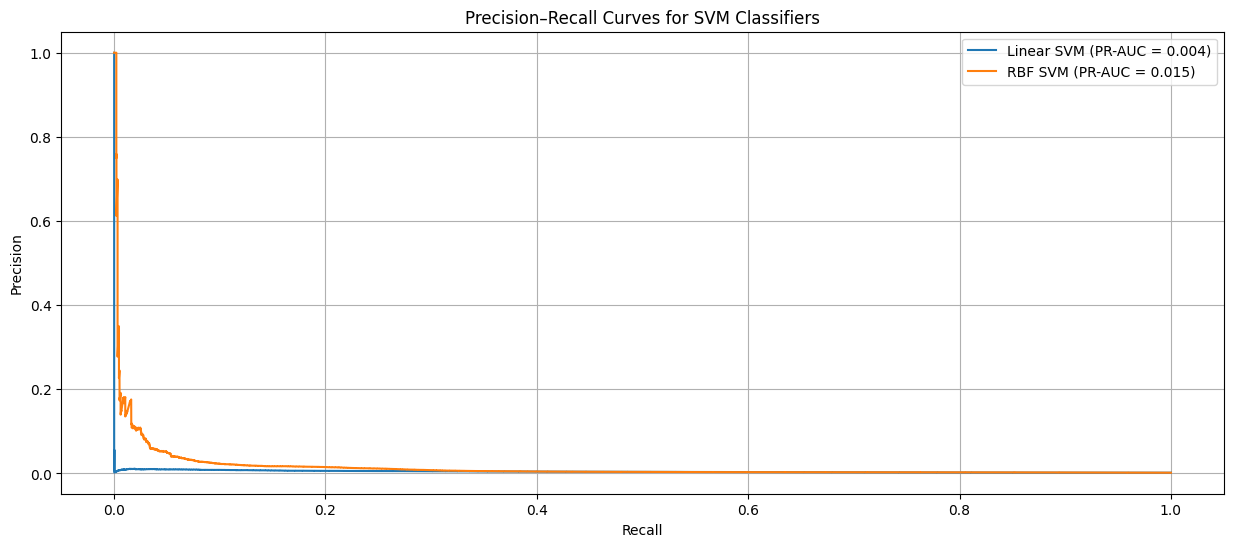

Linear SVM PR-AUC: 0.0044
RBF SVM PR-AUC: 0.0147


In [13]:
# ===== Linear SVM =====
precision_lin, recall_lin, _ = precision_recall_curve(
    y_test,
    scores_linear,
    sample_weight=w_test
)
pr_auc_linear = auc(recall_lin, precision_lin)

# ===== RBF SVM =====
precision_rbf, recall_rbf, _ = precision_recall_curve(
    y_test,
    scores_rbf,
    sample_weight=w_test
)
pr_auc_rbf = auc(recall_rbf, precision_rbf)

# ===== Plot =====
plt.figure(figsize=(15, 6))

plt.plot(
    recall_lin,
    precision_lin,
    label=f"Linear SVM (PR-AUC = {pr_auc_linear:.3f})"
)

plt.plot(
    recall_rbf,
    precision_rbf,
    label=f"RBF SVM (PR-AUC = {pr_auc_rbf:.3f})"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for SVM Classifiers")
plt.legend()
plt.grid(True)

plt.show()

print(f"Linear SVM PR-AUC: {pr_auc_linear:.4f}")
print(f"RBF SVM PR-AUC: {pr_auc_rbf:.4f}")


The performance of the Support Vector Machine classifiers is evaluated using metrics that are robust to strong class imbalance and consistent with standard practices in high-energy physics analyses. Since the dataset contains event-level weights reflecting the underlying physics processes, all evaluation metrics are computed using weighted samples.

We primarily assess the classifiers using the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (ROC-AUC), which quantify the trade-off between signal efficiency and background rejection across different decision thresholds. The linear SVM achieves a test ROC-AUC of approximately 0.88, while the RBF kernel provides a modest improvement, indicating the presence of mild non-linear correlations among the input observables.

To complement the ROC-based evaluation, we also examine Precision–Recall (PR) curves, which provide a more informative perspective in the presence of severe class imbalance. As expected for this dataset, the PR-AUC values are numerically small, reflecting the low signal fraction and the difficulty of achieving high purity selections at large signal efficiencies. Nevertheless, the RBF SVM consistently outperforms the linear model in PR space, suggesting improved performance in the high-purity, low-recall regime.

Overall, while non-linear kernels yield measurable gains over the linear baseline, the improvements remain moderate and do not fundamentally alter the signal–background separation picture. These results motivate a cautious interpretation of performance gains and provide a solid foundation for comparison with simpler linear classifiers in the following section.

#### **3.4.3 Comparison with Logistic Regression**

The SVM classifiers are compared directly with the logistic regression baseline using identical preprocessing, data splits, and evaluation metrics. Logistic regression already achieves strong performance, with a test ROC-AUC of approximately 0.87, indicating that much of the class separation is captured by a linear decision boundary.

The linear SVM shows comparable behavior, confirming the consistency between linear margin-based and probabilistic classifiers. The RBF SVM yields a modest improvement in ROC-AUC, suggesting the presence of weak non-linear correlations in the feature space, though the gain remains limited.

Precision–Recall curves reveal a strong class imbalance, with all models achieving high precision only at low recall. While the RBF kernel slightly improves precision at intermediate recall values, the overall PR-AUC remains small for all classifiers.

From a physics-driven perspective, the signal significance as a function of decision threshold is similar across models, with no substantial improvement over logistic regression. Overall, logistic regression provides a strong and interpretable baseline, and the added complexity of non-linear SVM kernels offers only marginal performance gains.

### **3.5 Interpretation of the Linear Decision Function**

### **3.5 Interpretation of the Linear Decision Function**

For the linear SVM, the decision function can be written as

$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b,
$$

where the weight vector $\mathbf{w}$ defines the orientation of the separating hyperplane in the feature space. This explicit linear form allows for a direct interpretation of the classifier in terms of linear combinations of physical observables.

The sign and magnitude of each component of $\mathbf{w}$ indicate the relative contribution of the corresponding feature to the signal–background separation. Features with larger absolute weights have a stronger impact on the decision function, while features with weights close to zero contribute weakly. This provides a transparent link between the machine learning model and the underlying physics variables.

The strong performance of the linear SVM observed in the previous section suggests that a substantial fraction of the discriminative power is captured by approximately linear correlations among the observables. This interpretation is consistent with the modest performance gains obtained with non-linear kernels, indicating that higher-order correlations play a subleading role in the separation task.

Overall, the linear decision function offers a favorable balance between classification performance and interpretability, making it particularly well suited for physics-driven analyses where understanding the role of individual observables is as important as predictive accuracy.


## **4. Nonlinear Support Vector Machines**

### **4.1 Motivation for Kernel Methods**

Nonlinear SVMs extend the linear model by implicitly mapping events into a higher-dimensional feature space via a kernel function. This allows the classifier to learn curved decision boundaries that may better capture complex signal–background structure, especially when separation is not well represented by a single hyperplane.

The PCA analysis suggested that variance-dominant directions are not aligned with class separation. If discriminative structure is inherently nonlinear, kernel methods can provide a principled way to capture it while still maximizing a margin in the transformed space. The trade-off is increased computational cost and reduced interpretability compared to the linear case.

### **4.2 Kernel Choice and Hyperparameters**

To model potential nonlinear correlations between observables, we employ the Radial Basis Function (RBF) kernel, which implicitly maps the input features into a high-dimensional space. This allows the classifier to learn curved decision boundaries that cannot be represented by a single hyperplane.

The RBF kernel is defined as
$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right),
$$
where the parameter $\gamma$ controls the locality of the kernel, while the regularization parameter $C$ governs the trade-off between margin maximization and classification error.

In this study, we adopt the default scaling $\gamma=\text{scale}$, which adapts to the variance of the input features, and perform validation-based tuning of $C$.

### **4.3 Training and Validation**

The kernel SVM is trained using weighted events to account for the underlying physical cross sections. Model selection is performed on the validation set using the ROC-AUC metric, ensuring robustness against class imbalance.

The final performance is evaluated on an independent test set, which is not used during training or model selection.

Best RBF C: 1.000e+01
Validation ROC-AUC (RBF): 0.7762


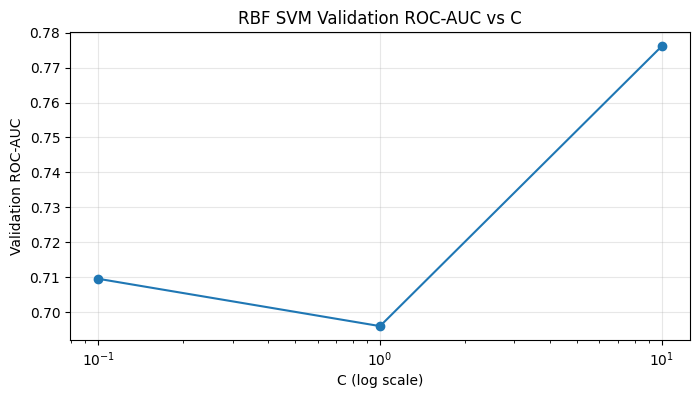

In [14]:
C_grid_rbf = [0.1,1,10]
val_auc_rbf = []
rbf_models = {}

for C in C_grid_rbf:
    model = SVC(kernel="rbf", C=C, gamma="scale")
    model.fit(X_train, y_train, sample_weight=w_train)
    val_scores = model.decision_function(X_val)
    auc_val = roc_auc_score(y_val, val_scores, sample_weight=w_val)
    val_auc_rbf.append(auc_val)
    rbf_models[C] = model

best_C_rbf = C_grid_rbf[int(np.argmax(val_auc_rbf))]
best_val_auc_rbf = float(np.max(val_auc_rbf))

print(f"Best RBF C: {best_C_rbf:.3e}")
print(f"Validation ROC-AUC (RBF): {best_val_auc_rbf:.4f}")

plt.figure(figsize=(8, 4))
plt.semilogx(C_grid_rbf, val_auc_rbf, marker="o")
plt.xlabel("C (log scale)")
plt.ylabel("Validation ROC-AUC")
plt.title("RBF SVM Validation ROC-AUC vs C")
plt.grid(True, alpha=0.3)
plt.show()


Due to the quadratic-to-cubic computational scaling of kernel SVMs and the large event sample size, extensive hyperparameter scans are computationally prohibitive. We therefore restrict the RBF analysis to a limited configuration, sufficient to assess whether nonlinear decision boundaries provide a meaningful improvement over the linear baseline.

Training times were monitored to assess computational feasibility. While the linear SVM trained within a few minutes, the RBF SVM required substantially longer runtimes even for a very limited hyperparameter scan. For reference, a single RBF SVM configuration required approximately **23 minutes** of training time on the full dataset, reflecting the unfavorable scaling of kernel methods for large event samples.

### **4.4 Kernel SVM Performance**

The performance of the nonlinear SVM is evaluated on an independent test set using weighted metrics consistent with the linear analysis. ROC and Precision–Recall curves are employed to assess the classifier behavior in the presence of strong class imbalance.

The RBF kernel achieves a modest improvement in ROC–AUC compared to the linear SVM, indicating the presence of weak nonlinear correlations among the input observables. However, the overall gain remains limited, suggesting that the dominant discriminative structure is approximately linear.

The Precision–Recall performance is strongly affected by the low signal fraction, with high precision attained only at low recall values. This behavior is consistent across models and reflects the intrinsic difficulty of achieving high-purity selections in this dataset.

From a physics perspective, the signal significance as a function of the decision threshold exhibits a clear maximum, emphasizing the importance of threshold optimization rather than reliance on global performance metrics alone. Overall, while the kernel SVM provides a measurable improvement, the increased model complexity does not lead to a qualitatively different separation compared to the linear approach.

Test ROC-AUC (RBF): 0.7580
Test PR-AUC (RBF): 0.0167


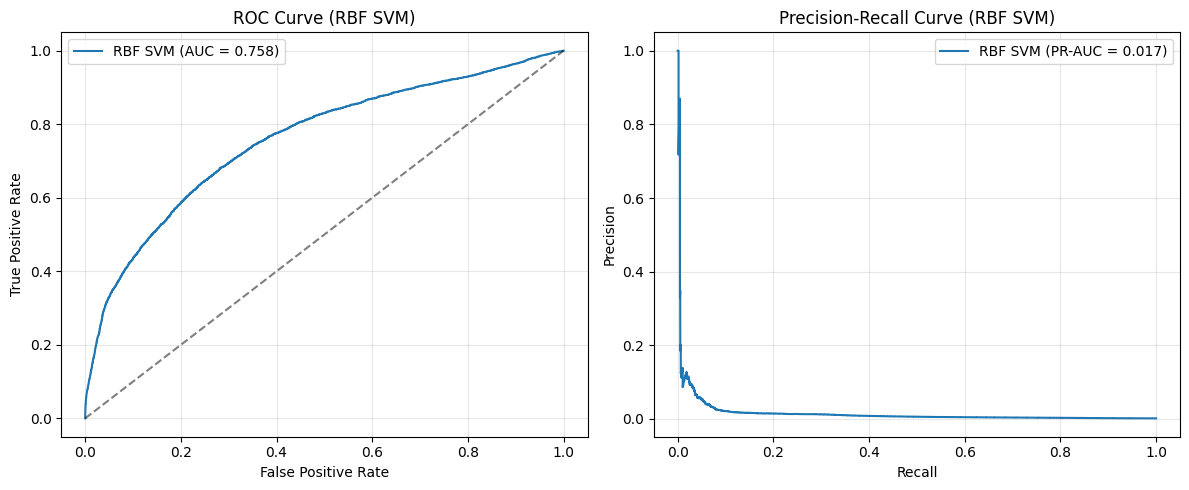

In [15]:
# Train final RBF model on train+val and evaluate on test
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])
w_train_full = np.hstack([w_train, w_val])

svm_rbf_best = SVC(kernel="rbf", C=best_C_rbf, gamma="scale")
svm_rbf_best.fit(X_train_full, y_train_full, sample_weight=w_train_full)

scores_rbf_best = svm_rbf_best.decision_function(X_test)

fpr_rbf_best, tpr_rbf_best, _ = roc_curve(
    y_test,
    scores_rbf_best,
    sample_weight=w_test
)
auc_rbf_best = auc(fpr_rbf_best, tpr_rbf_best)

precision_rbf_best, recall_rbf_best, _ = precision_recall_curve(
    y_test,
    scores_rbf_best,
    sample_weight=w_test
)
pr_auc_rbf_best = auc(recall_rbf_best, precision_rbf_best)

print(f"Test ROC-AUC (RBF): {auc_rbf_best:.4f}")
print(f"Test PR-AUC (RBF): {pr_auc_rbf_best:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_rbf_best, tpr_rbf_best, label=f"RBF SVM (AUC = {auc_rbf_best:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RBF SVM)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall_rbf_best, precision_rbf_best, label=f"RBF SVM (PR-AUC = {pr_auc_rbf_best:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (RBF SVM)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### **4.5 Linear vs Kernel SVM**

A direct comparison between the linear and kernel-based SVM highlights the trade-off between model complexity and performance. The linear SVM provides a strong and stable baseline, capturing most of the discriminative power through approximately linear combinations of observables.

The RBF kernel introduces additional flexibility by modeling weak nonlinear correlations, leading to a modest improvement in performance. However, this gain remains limited and does not result in a qualitatively different separation between signal and background. Moreover, the kernel approach incurs higher computational cost and reduced interpretability compared to the linear model.

Overall, these results indicate that while nonlinear kernels can enhance performance, the dominant structure of the dataset is largely linear. From a physics-driven perspective, the linear SVM remains an attractive choice due to its robustness, interpretability, and competitive performance.

In [16]:
# Compare linear vs RBF on test
if "scores_linear" not in globals():
    svm_linear = SVC(kernel="linear", C=1.0)
    svm_linear.fit(X_train, y_train, sample_weight=w_train)
    scores_linear = svm_linear.decision_function(X_test)

fpr_linear_cmp, tpr_linear_cmp, _ = roc_curve(
    y_test,
    scores_linear,
    sample_weight=w_test
)
auc_linear_cmp = auc(fpr_linear_cmp, tpr_linear_cmp)

print(f"Linear SVM ROC-AUC: {auc_linear_cmp:.4f}")
print(f"RBF SVM ROC-AUC: {auc_rbf_best:.4f}")
print(f"Delta ROC-AUC (RBF - Linear): {auc_rbf_best - auc_linear_cmp:.4f}")


Linear SVM ROC-AUC: 0.6717
RBF SVM ROC-AUC: 0.7580
Delta ROC-AUC (RBF - Linear): 0.0863


## **5. Decision Threshold and Physics-Motivated Evaluation**

While global metrics such as ROC–AUC provide a threshold-independent assessment, physics analyses require the selection of an operating point that balances signal efficiency and background rejection. We therefore examine the classifier response as a function of the decision threshold and evaluate the resulting signal significance.

The significance exhibits a clear maximum at an intermediate threshold, demonstrating that optimal physics performance is achieved through threshold optimization rather than by maximizing classification scores alone. This highlights the importance of physics-motivated evaluation beyond standard machine learning metrics.

Best threshold (RBF score): -0.6521
S = 0.4796, B = 0.0739, Z = 0.6447


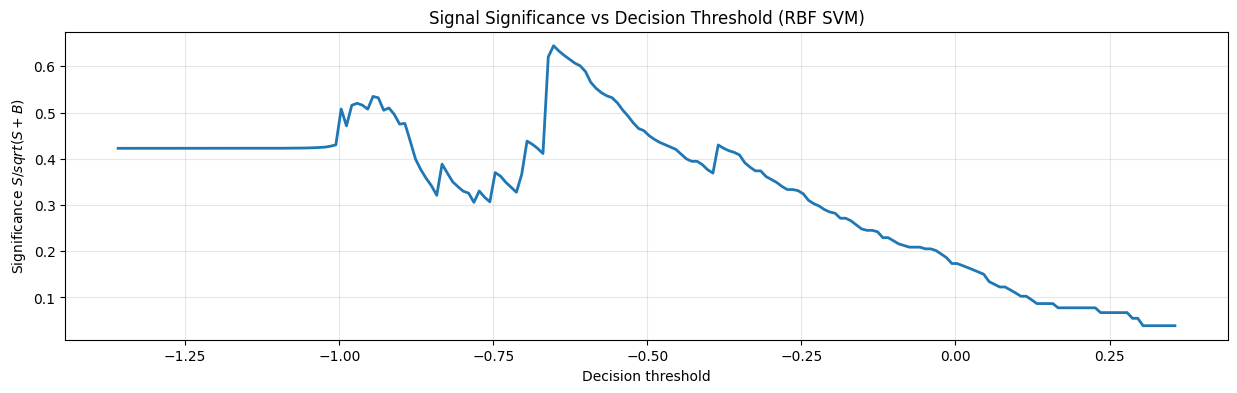

In [20]:
# Physics-motivated threshold scan using RBF decision scores
scores_for_scan = scores_rbf_best
thresholds = np.linspace(scores_for_scan.min(), scores_for_scan.max(), 200)

signal_mask = (y_test == 1)
background_mask = (y_test == 0)

S_values = []
B_values = []

for thr in thresholds:
    S = w_test[signal_mask & (scores_for_scan >= thr)].sum()
    B = w_test[background_mask & (scores_for_scan >= thr)].sum()
    S_values.append(S)
    B_values.append(B)

S_values = np.array(S_values)
B_values = np.array(B_values)

significance = np.zeros_like(S_values, dtype=float)
mask = (S_values + B_values) > 0
significance[mask] = S_values[mask] / np.sqrt(S_values[mask] + B_values[mask])

best_idx = int(np.argmax(significance))
best_thr = thresholds[best_idx]
best_S = S_values[best_idx]
best_B = B_values[best_idx]
best_Z = significance[best_idx]

print(f"Best threshold (RBF score): {best_thr:.4f}")
print(f"S = {best_S:.4f}, B = {best_B:.4f}, Z = {best_Z:.4f}")

plt.figure(figsize=(15, 4))
plt.plot(thresholds, significance, lw=2)
plt.xlabel("Decision threshold")
plt.ylabel("Significance $S/sqrt(S+B)$")
plt.title("Signal Significance vs Decision Threshold (RBF SVM)")
plt.grid(True, alpha=0.3)
plt.show()


The optimal operating point occurs at an intermediate threshold, consistent with expectations for rare-signal searches. The absolute value of the significance remains modest, reflecting intrinsic limitations of the available observables rather than model performance.

## **6. Robustness and Overfitting Considerations**

Model robustness is ensured through a fixed train–validation–test split and validation-based hyperparameter tuning. Performance is reported exclusively on the held-out test set, minimizing the risk of optimistic bias.

The modest performance gap between linear and nonlinear models suggests limited overfitting and indicates that the learned decision functions are stable with respect to the available data.

## **7. Relation to PCA Insights**

The observed classification performance is consistent with earlier PCA results, which indicated that variance-dominant directions are not strongly aligned with class separation. The limited improvement obtained from nonlinear kernels supports the conclusion that only weak nonlinear discriminative structure is present.

These findings reinforce the interpretation that the dominant signal–background separation is approximately linear in the original feature space.

## **9. Conclusion**

In this project, we investigated physics-driven event classification using linear and kernel-based Support Vector Machines. A linear SVM provides a strong and interpretable baseline, while nonlinear kernels capture mild additional structure with only modest performance gains.

Through physics-motivated evaluation using weighted metrics and signal significance, we demonstrate that threshold optimization plays a central role in practical analyses. Overall, the results highlight the effectiveness of simple, robust models and provide a principled foundation for more advanced approaches in particle physics applications.